# Grid Universe Tutorial

Welcome to the Grid Universe tutorial. This notebook guides you through the core mechanics of the environment step by step, gradually introducing new entity types, objectives, and interactions. Follow along in order; each section builds on earlier concepts.

## Overview
Grid Universe is a flexible, grid‑based environment in which you implement an agent that interacts with diverse gameplay mechanics to fulfil different objectives.

Setup instructions are in `README.md`. Once your environment is ready, work through the levels below. Each level introduces exactly one new mechanic and builds on the previous ones.

In [1]:
# Asset root for rendering. You can change this if you want to use custom game assets.
ASSET_ROOT = "data/assets/"

In [2]:
# Unified imports for Grid Universe tutorial (run this cell first)
from typing import List, Tuple

# Core API
from grid_universe.levels.grid import Level
from grid_universe.state import State
from grid_universe.levels.convert import to_state, from_state
from grid_universe.actions import Action
from grid_universe.step import step

# Factories
from grid_universe.levels.factories import (
    create_floor, create_agent, create_box, create_coin, create_exit, create_wall,
    create_key, create_door, create_portal, create_core, create_hazard, create_monster,
    create_phasing_effect, create_speed_effect, create_immunity_effect,
)

# Movement and objectives
from grid_universe.moves import default_move_fn
from grid_universe.objectives import (
    exit_objective_fn, default_objective_fn, all_pushable_at_exit_objective_fn, all_unlocked_objective_fn,
)

# Components and enums
from grid_universe.components.properties import Moving
from grid_universe.components.properties.moving import MovingAxis
from grid_universe.components.properties.appearance import AppearanceName
from grid_universe.components.properties.pathfinding import PathfindingType

# Rendering and display
from grid_universe.renderer.texture import TextureRenderer
from IPython.display import display

# Default renderer used throughout the notebook unless overridden in a cell
renderer = TextureRenderer(resolution=240, asset_root=ASSET_ROOT)
renderer_large = TextureRenderer(resolution=480, asset_root=ASSET_ROOT)

## Grid Universe API

Before we dive into mechanics, here’s a compact primer of Grid Universe API. If you’re building an agent, this is the part you’ll use the most.

- `Level`: authoring-time grid you can edit (add/remove objects), plus simple attributes.
- `EntitySpec`: the mutable blueprint of an entity; it’s a bag of components (agent, blocking, moving, etc.). Factories give you ready-made specs.
- `State`: immutable snapshot used by the engine/simulator; maps Entity IDs to components.
- `Step`: the pure transition function. state, action -> next_state, updating score and terminal flags via the configured objective_fn.

> Tip: You can convert back and forth between `Level` and `State` when needed (see examples below).

### Level

Authoring-time grid with a simple editing API.

Attributes:
- `width`, `height`: grid dimensions in tiles.
- `move_fn` (`MoveFn`): movement candidate generator used later by the simulator.
- `objective_fn` (`ObjectiveFn`): goal predicate evaluated after each step to set win/lose.
- `seed`: optional RNG seed for reproducibility of procedural bits.
- `grid`: a 2D array where `grid[y][x]` is a list of EntitySpec at that cell.
- Meta fields: `turn`, `score`, `win`, `lose`, `message`, `turn_limit`.

Relevant operations for authoring/modifying `Level` object:
- `add(pos, obj)`: place an `EntitySpec` at pos `(x, y)`.
- `add_many(items)`: bulk add `[(pos, obj), ...]`.
- `remove(pos, obj) -> bool`: remove by identity from a cell.
- `remove_if(pos, predicate) -> int`: remove all for which predicate(obj) is True.
- `move_obj(from_pos, obj, to_pos) -> bool`: move a specific object by identity.
- `clear_cell(pos) -> int`: remove everything from a cell.
- `objects_at(pos) -> List[EntitySpec]`: shallow copy of the cell contents.

Notes and errors:
- Out-of-bounds access raises `IndexError`.
- `remove` returns `False` if the object isn’t found; `remove_if` returns the count removed.

Tip:
- `Level` is useful to construct a starting state. To use with the Grid Universe engine, convert it into an engine-compatible `State` using `to_state(level)`. You can also reconstruct a `Level` from a `State` using `from_state(state)` for debugging/visualization when needed (more on this later).

Example:

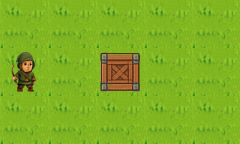

Objects @ (0,1): ['floor', 'human']
Objects @ (2,1): ['floor', 'box']
Removed pushables at (2,1): 1
Objects @ (2,1) now: ['floor']


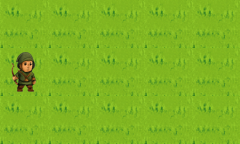

In [3]:
level = Level(width=5, height=3, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=123)

# Fill background
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

# Place an agent and a box (blocking/pushable)
hero = create_agent(health=5)
crate = create_box(pushable=True)
level.add((0, 1), hero)
level.add((2, 1), crate)

# Set an objective function (for win detection)
level.objective_fn = exit_objective_fn

display(renderer.render(to_state(level)))

print("Objects @ (0,1):", [o.appearance.name.value for o in level.objects_at((0, 1))])
print("Objects @ (2,1):", [o.appearance.name.value for o in level.objects_at((2, 1))])
removed = level.remove_if((2, 1), lambda o: o.pushable is not None)
print("Removed pushables at (2,1):", removed)
print("Objects @ (2,1) now:", [o.appearance.name.value for o in level.objects_at((2, 1))])

display(renderer.render(to_state(level)))

### EntitySpec

EntitySpec is a mutable bag of components. It represents a single entity specification.

Key attributes:
- `agent`, `appearance`, `blocking`, `collectible`, `collidable`, `cost`, `damage`, `exit`, `health`,
  `inventory`, `key`, `lethal_damage`, `locked`, `moving`, `pathfinding`, `portal`, `pushable`,
  `required`, `rewardable`, `status`.
- Effects (collected via Status): `immunity`, `phasing`, `speed`, `time_limit`, `usage_limit`.

Additional fields:
- `inventory_list`, `status_list`: list of `EntitySpec` which are items (for inventory) or effects (for status).
- `pathfind_target_ref`, `pathfinding_type`: reference to the target of pathfinding AI and the type of pathfinding AI.
- `portal_pair_ref`: reference to a portail pair.

Useful operations:
- Access component presence/details directly via attributes, e.g., `spec.agent is not None`.
- Use factories to create common specs: `create_floor`, `create_agent`, `create_box`, `create_coin`, ...

Example:

In [4]:
# Build a few specs
spec_floor = create_floor()
spec_agent = create_agent()
spec_box = create_box(pushable=True)
spec_coin = create_coin(reward=5)

# Check component presence
print("Agent has agent component:", spec_agent.agent is not None)
print("Box is pushable:", spec_box.pushable is not None)

# Set/update a property: make the box move horizontally to the right
spec_box.moving = Moving(axis=MovingAxis.HORIZONTAL, direction=1, bounce=True, speed=1)
print("Box moving component:", spec_box.moving)

Agent has agent component: True
Box is pushable: True
Box moving component: Moving(axis=<MovingAxis.HORIZONTAL: 'horizontal'>, direction=1, bounce=True, speed=1, prev_position=None)


### State

State is the immutable, engine-facing snapshot at a single turn.

Global attributes:
- `width`, `height`: grid dimensions.
- `move_fn` (`MoveFn`): movement candidate generator used by movement.
- `objective_fn` (`ObjectiveFn`): goal predicate used to set win/lose after steps.
- `seed`: optional RNG seed carried for determinism.

Component stores (mapping from `EntityID` to component):
- Effects: `immunity`, `phasing`, `speed`, `time_limit`, `usage_limit`.
- Properties: `agent`, `appearance`, `blocking`, `collectible`, `collidable`, `cost`, `damage`, `dead`,
  `exit`, `health`, `inventory`, `key`, `lethal_damage`, `locked`, `moving`, `pathfinding`, `portal`,
  `position`, `pushable`, `required`, `rewardable`, `status`.

Auxiliary stores (populated by engine):
- `prev_position`: snapshot before movement this step.
- `trail`: positions traversed this step -> set of `EntityID`.
- `damage_hits`: per-action damage tracking.

Status/meta:
- `turn`, `score`, `win`, `lose`, `message`, `turn_limit`.

Useful operations:
- Get agent id: `next(iter(state.agent.keys()), None)`
- Lookup component: `state.position.get(eid)`, `eid in state.blocking`
- Iterate entities in a cell: invert `state.position` to map `Position -> [EntityID]`
- Sparse debug view: `state.description` returns a `PMap` of populated fields.

Conversions:
- `to_state(level)` -> `State`: user-friendly mutable `Level` → immutable `State`.
- `from_state(state)` -> `Level`: useful for visualization or editing workflows.

**Important**: `trail` and `prev_position` are NOT stored in Level.

Example:

Component stores present: ['collidable', 'cost', 'inventory', 'appearance', 'health', 'agent', 'position', 'status']


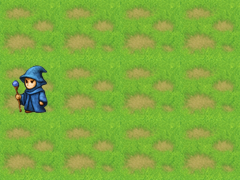

Agent position: Position(x=0, y=1)
Agent blocking? False
Round-trip Level size: 4 x 3


In [5]:
# Reuse a small authoring level
level2 = Level(width=4, height=3, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=27)
for y in range(level2.height):
    for x in range(level2.width):
        level2.add((x, y), create_floor())
agent2 = create_agent()
level2.add((0, 1), agent2)

state2 = to_state(level2)
print("Component stores present:", [name for name, store in state2.description.items() if hasattr(store, "__len__") and len(getattr(state2, name, {}))])

display(renderer.render(state2))

# Inspect components by EntityID
agent_id2 = next(iter(state2.agent.keys()))
print("Agent position:", state2.position.get(agent_id2))
print("Agent blocking?", agent_id2 in state2.blocking)

# Round-trip back to Level (useful for visualization/editing workflows)
round_trip_level = from_state(state2)
print("Round-trip Level size:", round_trip_level.width, "x", round_trip_level.height)

### Step (Simulator)

The step function is the simulator’s pure transition: given `(state, action[, agent_id])` it returns a new immutable State. It wires movement, pushing, autonomous movers, damage, portals, rewards, tile costs, status effects, and terminal checks in the correct order.

Contract (what you can rely on):
- Input: `State` (immutable), `Action` (enum), optional `agent_id` (defaults to first agent)
- Output: A new `State` snapshot; input `State` is never mutated
- Deterministic: With the same input `State` and `Action`, you’ll get the same next State
- Goal test in-state: `state.win` and `state.lose` updated per configured `objective_fn`
- Rewards/Cost in-state: `state.score` is updated appropriately

> Note that the `Action` enum here refers to the one defined in `grid_universe.actions`. It’s distinct from the same-named `Action` enum defined in `grid_universe.gym_env`, which is used to interact with the environment that adheres to the [Gymnasium spec](https://gymnasium.farama.org).

It basically combines transition function, action-cost/reward function, and goal test.

Notes:
- If the State is already terminal (win/lose) or invalid, step returns the same State (no-op)
- The configured `objective_fn` (on `Level`/`State`) controls how win is set (e.g., standing on exit, collecting required cores, etc.)

start: Position(x=0, y=1) score: 0 win: False


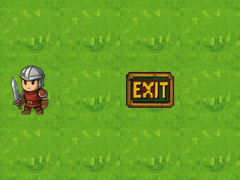

after RIGHT: Position(x=1, y=1) score: -1 win: False


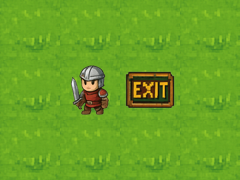

after RIGHT: Position(x=2, y=1) score: -1 win: True


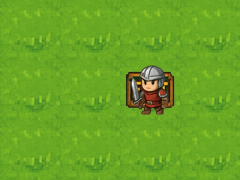

In [6]:
# Small example: reach exit in 2 moves
lvl = Level(width=4, height=3, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=1)
for y in range(lvl.height):
    for x in range(lvl.width):
        lvl.add((x, y), create_floor())
hero = create_agent()
lvl.add((0, 1), hero)
lvl.add((2, 1), create_exit())

s0 = to_state(lvl)
agent_id = next(iter(s0.agent.keys()))
print("start:", s0.position[agent_id], "score:", s0.score, "win:", s0.win)
display(renderer.render(s0))

# next state 1
s1 = step(s0, Action.RIGHT, agent_id)
print("after RIGHT:", s1.position[agent_id], "score:", s1.score, "win:", s1.win)
display(renderer.render(s1))

# next state 2 (goal)
s2 = step(s1, Action.RIGHT, agent_id)
print("after RIGHT:", s2.position[agent_id], "score:", s2.score, "win:", s2.win)
display(renderer.render(s2))

## Rendering

Grid Universe uses a texture-based renderer that turns a State into a composited RGBA image. In each cell, entities are layered using appearance metadata:

- Background(s): tiles with appearance.background=True (e.g., floor, wall, hazard, exit)
- Main: the highest-priority non-background entity (e.g., your agent)
- Corner icons: small icon entities (`appearance.icon=True`) shown in up to four corners (e.g., key, coin)
- Others: any remaining layered entities drawn between background and main

Additionally:
- Related groups (e.g., matching keys/locks, portal pairs) will be recolored consistently while preserving the original shading.
- For moving entities, a movement glyps overlay will be rendered on top of the entities.

### Overlapping Entities

A cell may contain multiple entities. Here's how entities are rendered.

- Overlapping: main entity (e.g., agent, enemy) on top of exit/floor/hazard (agent remains the main layer)
- Corner icons: main entity shares a cell with small items (key, coin), shown in tile corners

Below we render multiple different scenarios.

Agent + Key (corner icon)


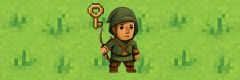

Agent + Key + Coin (multiple corner icons)


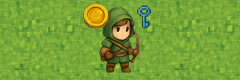

Overlapping: Agent on Exit (agent drawn on top)


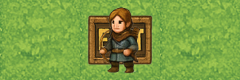

Overlapping: Agent on Hazard (agent drawn on top)


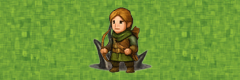

In [7]:

# 1) Agent + Key in the same cell (key appears as a small corner icon)
lvl_c1 = Level(width=3, height=1, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=2)
for x in range(lvl_c1.width):
    lvl_c1.add((x, 0), create_floor())

lvl_c1.add((1, 0), create_agent())  # main object
lvl_c1.add((1, 0), create_key(key_id=1))  # corner icon

state_c1 = to_state(lvl_c1)
print("Agent + Key (corner icon)")
display(renderer.render(state_c1))

# 2) Agent + Key + Coin in the same cell (multiple icons occupy different corners)
lvl_c2 = Level(width=3, height=1, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=3)
for x in range(lvl_c2.width):
    lvl_c2.add((x, 0), create_floor())

lvl_c2.add((1, 0), create_agent())  # main object
lvl_c2.add((1, 0), create_key(key_id=2))  # icon
lvl_c2.add((1, 0), create_coin())   # icon

state_c2 = to_state(lvl_c2)
print("Agent + Key + Coin (multiple corner icons)")
display(renderer.render(state_c2))

# 3) Overlapping: Agent on Exit (agent remains main; exit is background/other)
lvl_o1 = Level(width=3, height=1, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=4)
for x in range(lvl_o1.width):
    lvl_o1.add((x, 0), create_floor())

lvl_o1.add((1, 0), create_agent())
lvl_o1.add((1, 0), create_exit())

state_o1 = to_state(lvl_o1)
print("Overlapping: Agent on Exit (agent drawn on top)")
display(renderer.render(state_o1))

# 4) Overlapping: Agent on Hazard (e.g., spike or lava). Agent is main; hazard drawn beneath.
lvl_o2 = Level(width=3, height=1, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=5)
for x in range(lvl_o2.width):
    lvl_o2.add((x, 0), create_floor())

lvl_o2.add((1, 0), create_agent())
lvl_o2.add((1, 0), create_hazard(appearance=AppearanceName.SPIKE, damage=1))

state_o2 = to_state(lvl_o2)
print("Overlapping: Agent on Hazard (agent drawn on top)")
display(renderer.render(state_o2))

### Movement Overlay

Moving entities render small directional triangles on top of their texture:
- The direction is derived from the moving axis and sign of direction.
- The number of triangles equals the entity’s moving speed.

Below we render two moving crates to showcase the overlay.

Two vertical moving crates: speed=1 (one triangle up) and speed=3 (three triangles down)
Two horizontal moving crates: speed=1 (one triangle) and speed=2 (two triangles), opposite directions


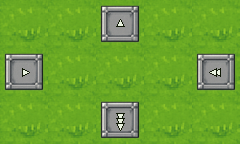

In [8]:
lvl_m = Level(width=5, height=3, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=6)
# Fill floors
for y in range(lvl_m.height):
    for x in range(lvl_m.width):
        lvl_m.add((x, y), create_floor())

# Add two moving crates with different directions/speeds
lvl_m.add((0, 1), create_box(pushable=False, moving_axis=MovingAxis.HORIZONTAL, moving_direction=1,  moving_bounce=True, moving_speed=1))
lvl_m.add((4, 1), create_box(pushable=False, moving_axis=MovingAxis.HORIZONTAL, moving_direction=-1, moving_bounce=True, moving_speed=2))

# Two crates with vertical motion: one up (direction=-1), one down (direction=+1)
lvl_m.add((2, 0), create_box(pushable=False, moving_axis=MovingAxis.VERTICAL, moving_direction=-1, moving_bounce=True, moving_speed=1))
lvl_m.add((2, 2), create_box(pushable=False, moving_axis=MovingAxis.VERTICAL, moving_direction=1,  moving_bounce=True, moving_speed=3))

state_m = to_state(lvl_m)
print("Two vertical moving crates: speed=1 (one triangle up) and speed=3 (three triangles down)")
print("Two horizontal moving crates: speed=1 (one triangle) and speed=2 (two triangles), opposite directions")
display(renderer.render(state_m))

### Group Recoloring (Keys/Doors, Portals)

Renderer applies deterministic group-based recoloring so related entities share a hue while preserving texture shading. We’ll show:
- Key/Door pairs with the same key_id.
- Two portals that belong to the same pair.

Key/Door group recolor (key_id='alpha')


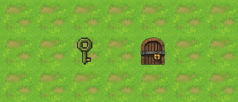

Portal pair group recolor


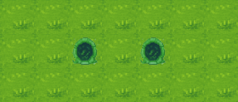

In [9]:
# 1) Key/Door pair share hue via key_id grouping
lvl_kd = Level(width=7, height=3, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=7)
for y in range(lvl_kd.height):
    for x in range(lvl_kd.width):
        lvl_kd.add((x, y), create_floor())

lvl_kd.add((2, 1), create_key(key_id="alpha"))
lvl_kd.add((4, 1), create_door(key_id="alpha"))
state_kd = to_state(lvl_kd)
print("Key/Door group recolor (key_id='alpha')")
display(renderer.render(state_kd))

# 2) Portal pair share hue via pair identifier
lvl_po = Level(width=7, height=3, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=8)
for y in range(lvl_po.height):
    for x in range(lvl_po.width):
        lvl_po.add((x, y), create_floor())

p = create_portal() # create a portal spec and reuse it as the 'pair'
lvl_po.add((2, 1), p)
lvl_po.add((4, 1), create_portal(pair=p))
state_po = to_state(lvl_po)
print("Portal pair group recolor")
display(renderer.render(state_po))

## Gameplay Mechanics

Each subsection introduces one mechanic with: (1) a short explanation, (2) a minimal example, and (3) a prompt for you to complete. A rolling summary table expands as you progress.

### Level 0 – Basic Movement
> Start with an empty lot. Objective: reach the exit. Nothing blocks you.

We'll maintain a table of learned mechanics for quick reference.
| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |

You control an agent on a fully observable grid. Movement is orthogonal (up, left, down, right).

In [10]:
level = Level(
    width=5,
    height=5,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=9,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

level.add((1, 2), create_agent(health=5))
level.add((3, 2), create_exit())

# 3) Convert to runtime State (immutable)
state = to_state(level)

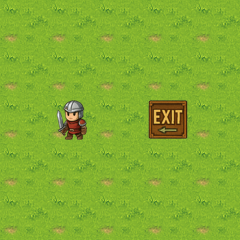

In [11]:
img = renderer.render(state)                 # PIL.Image (RGBA)

# Display image
img

Let's move around the maze. There are seven actions the agent can perform, but for this level we'll focus only on movement actions.

In [12]:
agent_id = next(iter(state.agent.keys()))

Moving 1 tile up...


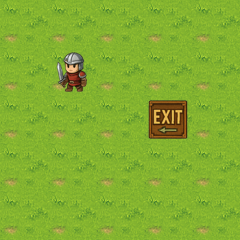

Moving 1 tile to the left...


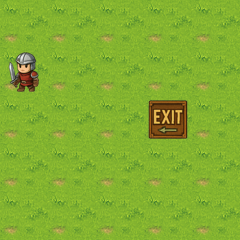

Moving 1 tile down...


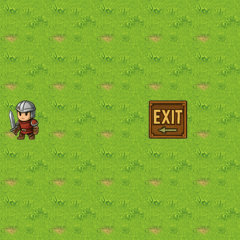

Moving 1 tile to the right...


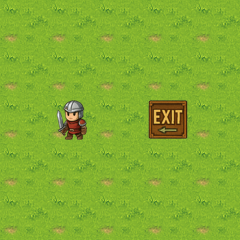

In [13]:
desc = {
    Action.UP: "Moving 1 tile up...",
    Action.LEFT: "Moving 1 tile to the left...",
    Action.DOWN: "Moving 1 tile down...",
    Action.RIGHT: "Moving 1 tile to the right...",
}

for a in [Action.UP, Action.LEFT, Action.DOWN, Action.RIGHT]:
    state = step(state, a, agent_id=agent_id)
    print(desc[a])
    display(renderer.render(state))

Now write the sequence of actions that gets you to the exit in this simple maze.

In [14]:
from typing import List

action_sequence: List[Action] = [Action.RIGHT, Action.RIGHT] # Fill in the sequence of actions here!

state = to_state(level)

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)
    

if state.win:
    print("Congratulations! You have exited the maze!")
else:
    print("You are stuck here, forever!!!")

Congratulations! You have exited the maze!


We just learnt how to navigate the grid world, but to actually exit it the agent needs to know how the grid is represented. Fortunately, Grid Universe is fully observable. Let's learn the `Level` and `State` representations.

The `Level` representation is a mutable, grid‑centric structure: each `Level` maintains a 2‑dimensional grid, and each cell holds a list of entities. Everything is an entity—floors, walls, the agent, the exit. This representation is efficient when the grid is dense. See `grid_universe/levels/grid.py` for details.

The `State` representation is immutable and stores the world as component collections. Instead of asking “what's in this cell?”, you ask “where is this entity?”. This is efficient when the grid is sparse. See `grid_universe/state.py` for details.

To convert a `Level` to a `State`:
```python
from grid_universe.levels.convert import to_state
state = to_state(level)
```

Now experiment with both representations using the same level and state defined above. Because they already exist, you can reference `level` and `state` directly in your functions.

In [15]:
# reset the state and agent ID
state = to_state(level)
agent_id = next(iter(state.agent.keys()))

In [ ]:
def get_agent_position_from_level_repr() -> Tuple[int, int]:
    for x in range(level.width):
        for y in range(level.height):
            if level.grid[y][x].agent is not None:
                return (x,y)
            

def get_agent_position_from_state_repr() -> Tuple[int, int]:
    # Now, try to get your (the agent's) position from the State representation by reading the position of the agent
    # Hint: `agent_id` has already been defined
    agent_id = next(iter(state.agent.keys()), None)
    agent_position = state.position.get(agent_id)
    return (agent_position.x, agent_position.y)

# Now, do the same thing for exit
def get_exit_position_from_level_repr() -> Tuple[int, int]:
    for x in range(level.width):
        for y in range(level.height):
            if level.grid[x][y].exit is not None:
                return (x,y)     
                
def get_exit_position_from_state_repr() -> Tuple[int, int]:
    exit_id = next(iter(state.exit.keys()), None)
    exit_position = state.position.get(exit_id)
    return (exit_position.x, exit_position.y)  

In [26]:
# Test
test = {}
test["agent-level"] = get_agent_position_from_level_repr() == (1, 2)
test["agent-state"] = get_agent_position_from_state_repr() == (1, 2)

print(get_agent_position_from_level_repr())
print(get_agent_position_from_state_repr())

test["exit-level"] = get_exit_position_from_level_repr() == (3, 2)
test["exit-state"] = get_exit_position_from_state_repr() == (3, 2)
test

AttributeError: 'list' object has no attribute 'agent'

Reminder: use `step` to transition between states. Check whether the objective is satisfied (here: exit the maze) with `state.win`.

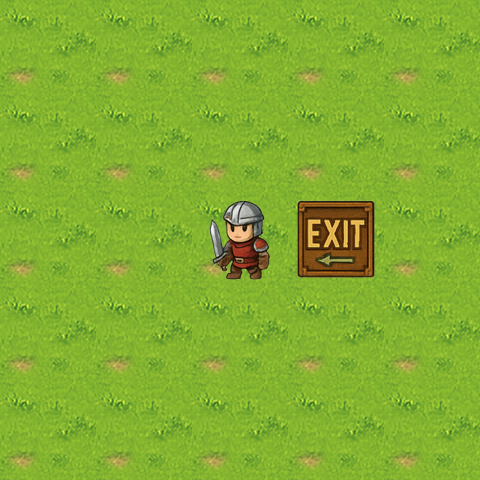

Haven't exited


In [30]:
next_state = step(state, Action.RIGHT, agent_id) # Expect to move the agent up by 1 tile
display(renderer_large.render(next_state))
print("Exited" if next_state.win else "Haven't exited") # expect "Haven't exited"

Now your agent understands the basics of the maze—time to increase difficulty.

### Level 1 - Maze Turns
> Some walls now block your path. You cannot step onto a wall.

| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |
| L1 | Maze turns | Blocking |

A wall is `Blocking`. After retrieving an `EntitySpec` from the `Level`, check `entity.blocking`. It returns a `Blocking` object if the entity blocks movement, else `None`. This applies to `Exit` and every other entity you will encounter.

In the `State` representation, enumerate all blocking entity IDs via `state.blocking.keys()`.

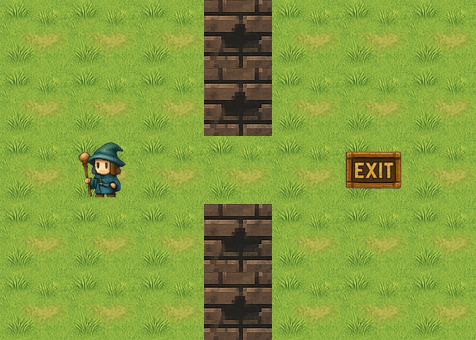

In [19]:
from grid_universe.levels.factories import create_wall

level = Level(
    width=7,
    height=5,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=10,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

level.add((1, 2), create_agent(health=5))
level.add((5, 2), create_exit())

level.add((3, 0), create_wall())
level.add((3, 1), create_wall())
level.add((3, 3), create_wall())
level.add((3, 4), create_wall())

# 3) Convert to runtime State (immutable)
state = to_state(level)
agent_id = next(iter(state.agent.keys()))
renderer_large.render(state)

Write the sequence of actions to solve this trivial maze.

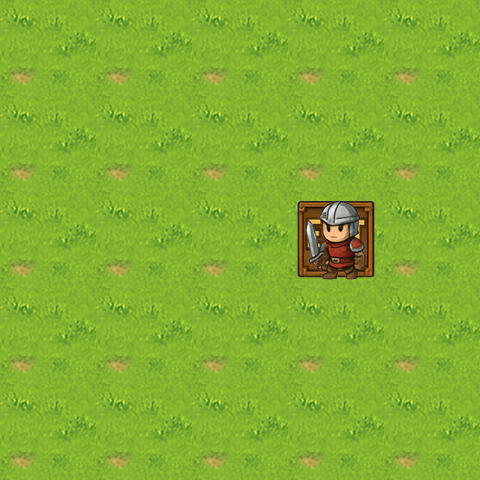

Congratulations! You have exited the maze!


In [31]:
action_sequence: List[Action] = [Action.RIGHT, Action.RIGHT, Action.RIGHT] # Fill in the sequence of actions here!

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))

if state.win:
    print("Congratulations! You have exited the maze!")
else:
    print("You are stuck here, forever!!!")

Now try this non‑trivial maze:

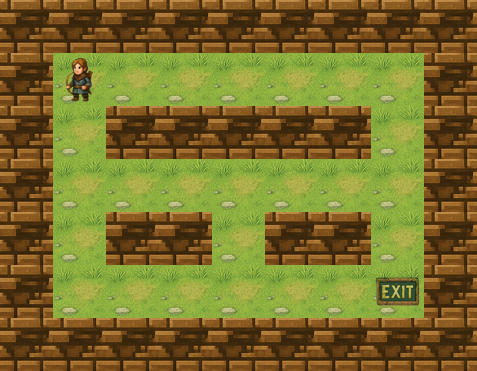

In [32]:
level = Level(
    width=9,
    height=7,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=11,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if y == 0 or y == level.height - 1 or x == 0 or x == level.width - 1:
            level.add((x, y), create_wall())

level.add((1, 1), create_agent(health=5))
level.add((7, 5), create_exit())

level.add((2, 2), create_wall())
level.add((3, 2), create_wall())
level.add((4, 2), create_wall())
level.add((5, 2), create_wall())
level.add((6, 2), create_wall())

level.add((2, 4), create_wall())
level.add((3, 4), create_wall())
level.add((5, 4), create_wall())
level.add((6, 4), create_wall())

# 3) Convert to runtime State (immutable)
state = to_state(level)
agent_id = next(iter(state.agent.keys()))
renderer_large.render(state)

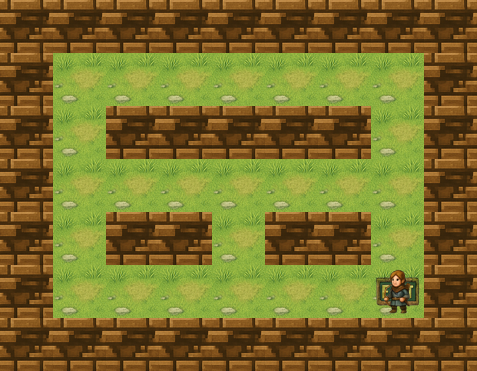

Congratulations! You have exited the maze!


In [34]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for i in range(6):
    action_sequence.append(Action.RIGHT)
for i in range(4):
    action_sequence.append(Action.DOWN)

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))

if state.win:
    print("Congratulations! You have exited the maze!")
else:
    print("You are stuck here, forever!!!")

### Level 2 - Optional Coins
> Enough pure navigation—let's think about economy.

Each action now incurs a uniform cost. Grid Universe does not require you to finish with a non‑negative score, but you naturally want to maximise score (i.e. minimise net cost). The grid kindly drops optional coins: collecting them offsets movement cost.

| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |
| L1 | Maze turns | Blocking |
| L2 | Optional Coins | Collectible, Rewardable, Cost |

New action: `Action.PICK_UP`.

When you perform it, you stay on the same tile and collect every `Collectible` there (coins are `Collectible`). Because it's an action, you cannot move and pick up in the same turn.

A `Rewardable` grants score (a coin is both `Collectible` and `Rewardable`). A `Cost` subtracts score (floors are a `Cost`).

**Important:** Every action ends with the agent standing on some floor tile, so all actions incur that floor's cost—even wasted ones. Trying to walk into a `Blocking` direction or picking up on an empty tile still costs a turn. If an action immediately fulfills the objective, no cost is applied.

Inspect an `EntitySpec` for `entity.rewardable`, `entity.collectible`, and `entity.cost` just like `entity.blocking` (we won't repeat this pattern later).

Retrieve current score via `state.score` (immutable) or `level.score` (mutable). If building your own state tracker:
- Any action has cost `a`. Picking up a coin with reward `c` yields net `(c - a)` that turn.

Try the pick‑up action and cost system below. Aim not to waste actions.

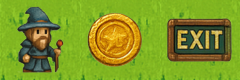

In [37]:
from grid_universe.levels.factories import create_coin

level = Level(
    width=3,
    height=1,
    move_fn=default_move_fn,
    objective_fn=exit_objective_fn,
    seed=12,
)


for y in range(level.height):
    for x in range(level.width):
        # When you perform any action, the cost is the cost of the tile that you stand on at the end of the action
        # If you move from tile A to tile B, the cost comes from tile B.
        # If you pick up an item on tile A, the cost comes from tile A.
        level.add((x, y), create_floor(cost_amount=1))

level.add((0, 0), create_agent())
level.add((1, 0), create_coin(reward=10)) # The coin rewards 10
level.add((2, 0), create_exit())          # The exit does not incur any cost

state = to_state(level)
agent_id = next(iter(state.agent.keys()))

display(renderer.render(state))

In [38]:
# Specify the list of actions that will bring you to the goal with minimal cost.
path: List[Action] = [Action.RIGHT,Action.PICK_UP,Action.RIGHT]

-1
8
8


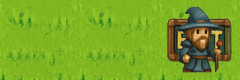

Congratulations! The agent reaches the exit with the minimum cost.


In [39]:
# Reset the state so that you only need to run this cell for testing
state = to_state(level)

agent_id = next(iter(state.agent.keys()))
for a in path:
    state = step(state, a, agent_id)
    print(state.score)

display(renderer.render(state))

if (not state.win):
    print("The agent has not reached the exit!")
elif (state.score < 8):
    print("The agent does not reach the exit with minimal cost")
else:
    print("Congratulations! The agent reaches the exit with the minimum cost.")

Now solve this slightly more complicated maze.

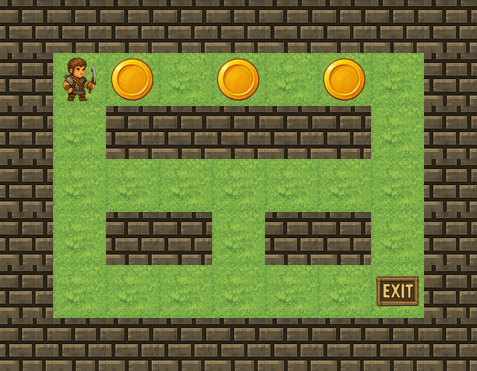

In [45]:
from grid_universe.levels.factories import create_coin

level = Level(
    width=9,
    height=7,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=13,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if y == 0 or y == level.height - 1 or x == 0 or x == level.width - 1:
            level.add((x, y), create_wall())

level.add((1, 1), create_agent(health=5))
level.add((7, 5), create_exit())

level.add((2, 2), create_wall())
level.add((3, 2), create_wall())
level.add((4, 2), create_wall())
level.add((5, 2), create_wall())
level.add((6, 2), create_wall())

level.add((2, 4), create_wall())
level.add((3, 4), create_wall())
level.add((5, 4), create_wall())
level.add((6, 4), create_wall())

level.add((2, 1), create_coin(reward=10))
level.add((4, 1), create_coin(reward=10))
level.add((6, 1), create_coin(reward=10))

# 3) Convert to runtime State (immutable)
state = to_state(level)
renderer_large.render(state)

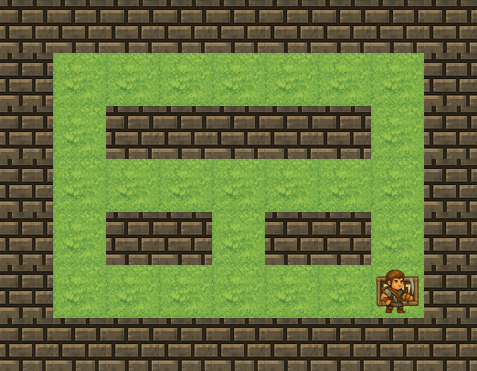

Congratulations! The agent reaches the exit with the minimum cost.


In [46]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for i in range(3):
    action_sequence.append(Action.RIGHT)
    action_sequence.append(Action.PICK_UP)
    action_sequence.append(Action.RIGHT)
for i in range(4):
    action_sequence.append(Action.DOWN)

agent_id = next(iter(state.agent.keys()))
for a in action_sequence:
    state = step(state, a, agent_id)

display(renderer_large.render(state))

if (not state.win):
    print("The agent has not reached the exit!")
elif (state.score < 18):
    print("The agent does not reach the exit with minimal cost")
else:
    print("Congratulations! The agent reaches the exit with the minimum cost.")

### Level 3, 4 - Required Core(s)
> Objective shift: you must collect required cores.

The grid now contains cores—collectible items that are mandatory. This introduces two new objectives:
- Collect all cores to win (escaping not required) → `collect_required_objective_fn`
- Collect all cores AND escape → `default_objective_fn`

| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |
| L1 | Maze turns | Blocking |
| L2 | Optional Coins | Collectible, Rewardable, Cost |
| L3 | One Required Core | Required |
| L4 | Two Required Cores | Required |

Because you must pick it up, a core is `Collectible`. Any mechanism required to clear the objective is marked `Required`.

From here on we focus on new mechanics and ignore scoring.

Try the new mechanic:

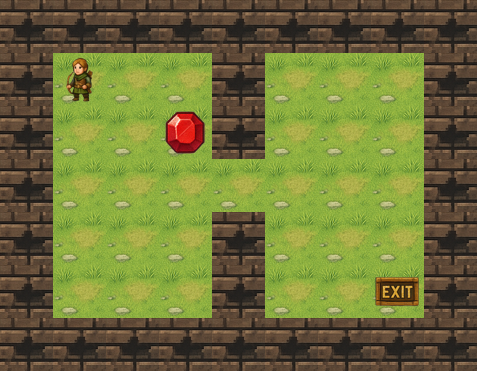

In [47]:
from grid_universe.levels.factories import create_core

level = Level(
    width=9,
    height=7,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=default_objective_fn,    # win when collecting all cores and standing on exit
    seed=14,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if y == 0 or y == level.height - 1 or x == 0 or x == level.width - 1:
            level.add((x, y), create_wall())

level.add((1, 1), create_agent(health=5))
level.add((7, 5), create_exit())

level.add((4, 1), create_wall())
level.add((4, 2), create_wall())
level.add((4, 4), create_wall())
level.add((4, 5), create_wall())

level.add((3, 2), create_core())

# 3) Convert to runtime State (immutable)
state = to_state(level)
renderer_large.render(state)

This maze has 1 core. Solve it.

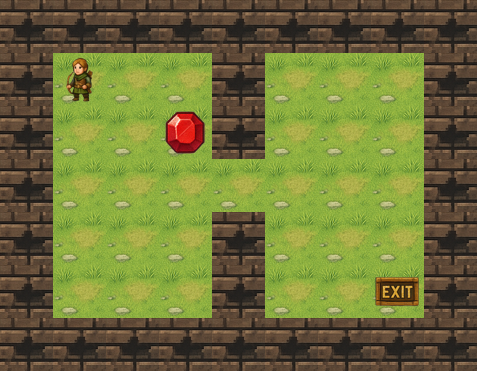

You are stuck here, forever!!!


In [ ]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!



agent_id = next(iter(state.agent.keys()))
for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))

if state.win:
    print("Congratulations! You have collected all cores and exited the maze!")
else:
    print("You are stuck here, forever!!!")

Now solve this maze with 2 cores.

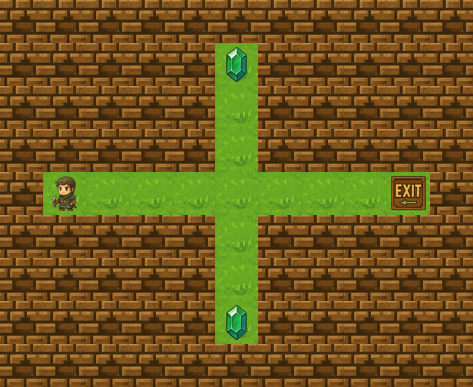

In [30]:
level = Level(
    width=11,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=default_objective_fn,    # win when collecting all cores and standing on exit
    seed=15,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if y == 0 or y == level.height - 1 or x == 0 or x == level.width - 1:
            level.add((x, y), create_wall())

level.add((1, 4), create_agent(health=5))
level.add((9, 4), create_exit())

level.add((5, 1), create_core())
level.add((5, 7), create_core())

for y in range(1, 8):
    for x in range(1, 10):
        if y == 4 or x == 5:
            continue

        level.add((x, y), create_wall())

# 3) Convert to runtime State (immutable)
state = to_state(level)
renderer_large.render(state)

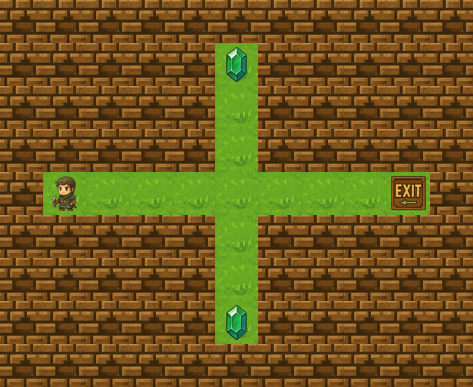

You are stuck here, forever!!!


In [31]:
# Specify the list of actions to fulfill the objective
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

agent_id = next(iter(state.agent.keys()))
for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))

if state.win:
    print("Congratulations! You have collected all cores and exited the maze!")
else:
    print("You are stuck here, forever!!!")

Note: If your algorithm benefits from knowing the objective function name, retrieve it with `state.objective_fn.__name__`.

In [32]:
state.objective_fn.__name__

'default_objective_fn'

### Level 5, 7 - Key-Door, Portals
> More interactive objects.

| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |
| L1 | Maze turns | Blocking |
| L2 | Optional Coins | Collectible, Rewardable, Cost |
| L3 | One Required Core | Required |
| L4 | Two Required Cores | Required |
| L5 | Key & Door | Key, Locked |
| L7 | Portal Shortcut | Portal |

Key–Door works as you'd expect: to unlock a door, pick up its key (`Action.PICK_UP`). A door may or may not guard the optimal route; your algorithm must decide whether detouring is worth it. New objective variant:

- Unlock all doors to win (independent of exit and core objectives) -> `all_unlocked_objective_fn`
- Any combination of the objectives.

To unlock: stand orthogonally adjacent to a door and use `Action.USE_KEY`. This action also has a cost. Using it without a key or without an adjacent door still wastes a turn.

A key is `Key`; a door is `Locked`. Access a door's requirement via `entity.locked.key_id`. If `None`, it can be opened by any key (or is permanently locked if keys are fewer than locks). Otherwise only the matching key ID works.

Try the mechanic:

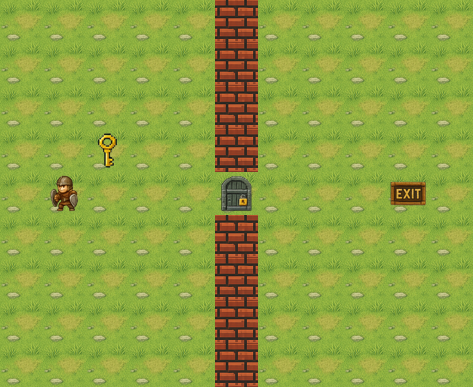

In [48]:
from grid_universe.levels.factories import create_door, create_key

level = Level(
    width=11,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=16,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if x == 5 and y != 4:
            level.add((x, y), create_wall())

level.add((1, 4), create_agent(health=5))
level.add((9, 4), create_exit())

level.add((5, 4), create_door(key_id="my_key"))
level.add((2, 3), create_key(key_id="my_key"))

# 3) Convert to runtime State (immutable)
state = to_state(level)
renderer_large.render(state)

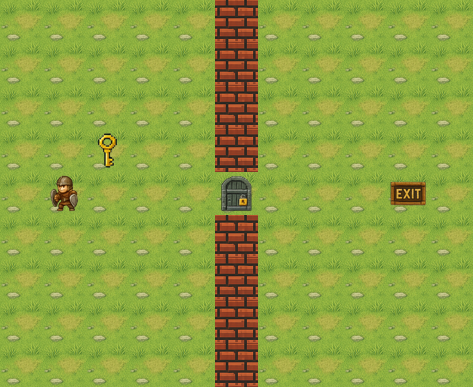

You are stuck here, forever!!!


In [ ]:
# Specify the list of actions to fulfill the objective
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

agent_id = next(iter(state.agent.keys()))
for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))

if state.win:
    print("Congratulations! You have collected all cores and exited the maze!")
else:
    print("You are stuck here, forever!!!")

Next: Portals. Stepping on a `Portal` instantly moves you to its paired `Portal`. Portals come in pairs; members share an ID accessible via `entity.portal.pair_entity`. If a `Blocking` entity shares a tile with a `Portal`, the blocking prevents teleportation onto that tile when approached from the other end.

NOTE: On maps with multiple Key–Door pairs, each pair has a unique colour; key and door of a pair share a colour. The same applies to portal pairs.

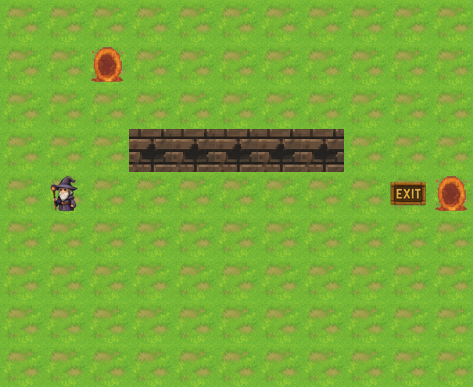

In [49]:
from grid_universe.levels.factories import create_portal

level = Level(
    width=11,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=17,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if 3 <= x <= 7 and y == 3:
            level.add((x, y), create_wall())

level.add((1, 4), create_agent(health=5))
level.add((9, 4), create_exit())

portal = create_portal()
level.add((2, 1), portal)
level.add((10, 4), create_portal(pair=portal))

# 3) Convert to runtime State (immutable)
state = to_state(level)
renderer_large.render(state)

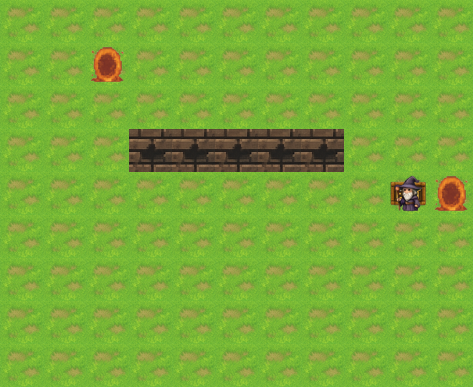

Congratulations! You have opened all doors and exited!


In [50]:
# Specify the list of actions to fulfill the objective
action_sequence: List[Action] = [Action.RIGHT, Action.UP, Action.UP, Action.UP, Action.LEFT] # Fill in the sequence of actions here!

# Re-initialise state so that you only need to run this cell
state = to_state(level)

agent_id = next(iter(state.agent.keys()))
for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))

if state.win:
    print("Congratulations! You have opened all doors and exited!")
else:
    print("You are stuck here, forever!!!")

### Level 8 - Pushing Boxes
> It's Sokoban—except there are cores, gated areas, and portals.

| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |
| L1 | Maze turns | Blocking |
| L2 | Optional Coins | Collectible, Rewardable, Cost |
| L3 | One Required Core | Required |
| L4 | Two Required Cores | Required |
| L5 | Key & Door | Key, Locked |
| L7 | Portal Shortcut | Portal |
| L8 | Pushing Boxes | Collidable, Moving, Pushable |

Boxes may be `Pushable`. There is no separate “push” action: attempting to move into a `Pushable` pushes it one tile in that direction (if free). Boxes are also `Blocking`; a non‑pushable box is just an obstacle. You cannot push multiple boxes in a line, nor push into a `Blocking` entity.

Boxes can be `Moving` (pre‑programmed motion). For this project, moving entities move at most 1 tile per turn. A direction arrow indicates intended next move. When direction changes, the entity spends that turn rotating (no displacement) and the arrow updates.

`Moving` attributes:
- `axis`: `MovingAxis.HORIZONTAL` or `MovingAxis.VERTICAL`
- `direction`: +1 or −1 step direction
- `bounce`: Whether to reverse at an edge instead of stopping
- `speed`: Tiles attempted per turn
- `prev_position`: Internal bookkeeping

Watch the box move for 10 turns:

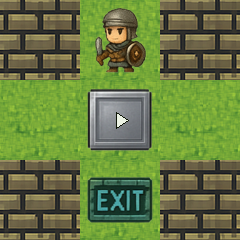

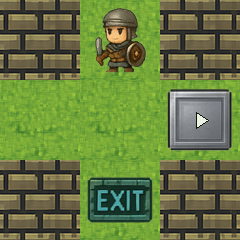

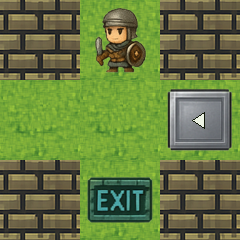

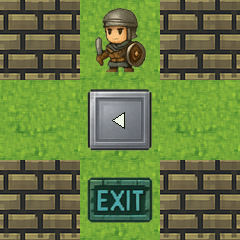

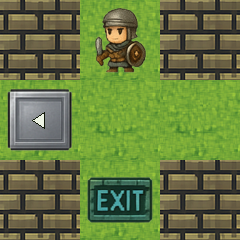

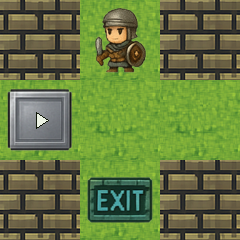

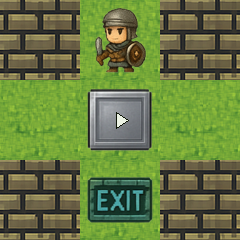

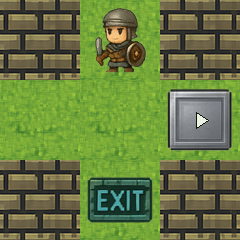

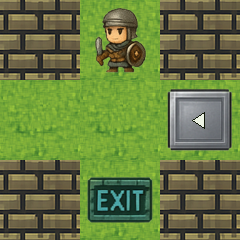

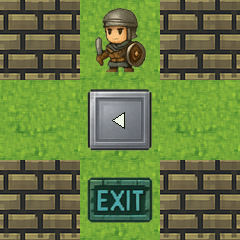

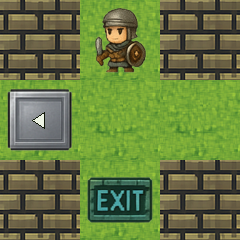

In [37]:
from grid_universe.levels.factories import create_box
from grid_universe.components.properties import MovingAxis

level = Level(3, 3, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=18)
for y in range(3):
    for x in range(3):
        level.add((x, y), create_floor())

for y, x in ((0, 0), (0, 2), (2, 0), (2, 2)):
    level.add((x, y), create_wall())

level.add((1, 0), create_agent())
level.add((1, 2), create_exit())

# This box cannot be pushed and will bounce off walls. 
box = create_box(
    pushable=False,
    moving_axis=MovingAxis.HORIZONTAL, 
    moving_direction=1,
    moving_bounce=True,
    moving_speed=1
)

level.add((1, 1), box)

state = to_state(level)

display(renderer.render(state))
agent_id = next(iter(state.agent.keys()))


for _ in range(10):
    state = step(state, Action.WAIT, agent_id)
    display(renderer.render(state))

Because the box movement is calculated **before** the agent, note the following caveats about a moving box:
- When the agent blocks the path of a moving (with bouncing), non-pushable box, in the next turn, the box is bounced, even if the agent is no longer on that tile on the next turn. The agent is not pushed by the box. For example, a box wants to move to tile (5, 5) in the next turn, but in this turn, the agent is there. If the agent , the box will be bounced the next turn.
- If the agent and a moving box competes for a tile, then the box takes precedence. For example, in turn 5, the agent is on tile (5, 5), a vertically-moving box is on tile (5, 7), and both of you want to move to tile (5, 6) in turn 6, then in turn 6, the box is on tile (5, 6) and the agent is still on tile (5, 5). 
- If two moving boxes compete for a tile, the box with the lower ID takes precedence. The private test cases ensure that you do not need to handle this.

A box is also `Collidable`. Any `Collidable` participates in special collision interactions. `Collidable` does not imply `Blocking` (blocking simply prevents entry). For example, a `Collidable` on a `Portal` (agent or box) will teleport. 

Now push this box through the portal:

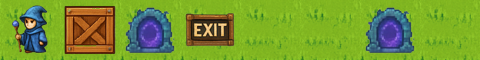

In [38]:
from grid_universe.levels.factories import create_box
from grid_universe.components.properties.moving import MovingAxis

level = Level(8, 1, move_fn=default_move_fn, objective_fn=exit_objective_fn, seed=19)
for y in range(8):
    for x in range(1):
        level.add((y, x), create_floor())

portal = create_portal()

level.add((0, 0), create_agent())
level.add((1, 0), create_box())
level.add((2, 0), portal)
level.add((6, 0), create_portal(pair=portal))
level.add((3, 0), create_exit())

# This box cannot be pushed and will bounce off walls. 
box = create_box(
    pushable=False,
    moving_axis=MovingAxis.HORIZONTAL, 
    moving_direction=1,
    moving_bounce=True,
    moving_speed=1
)

state = to_state(level)

display(renderer_large.render(state))
agent_id = next(iter(state.agent.keys()))

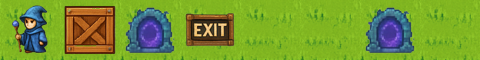

You are stuck here, forever!!!


In [39]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

agent_id = next(iter(state.agent.keys()))
for a in action_sequence:
    state = step(state, a, agent_id=agent_id)


display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have exited the maze!")
else:
    print("You are stuck here, forever!!!")

Introducing a new objective involving boxes:
- All boxes rest on exit tiles → `all_pushable_at_exit_objective_fn`
- Or any combination with previous objectives

Navigate this maze and explore the box mechanic. Observe which objective function is active.

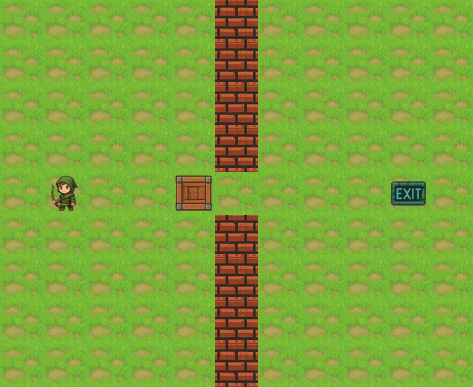

In [51]:
level = Level(
    width=11,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=20,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if x == 5 and y != 4:
            level.add((x, y), create_wall())

level.add((1, 4), create_agent(health=5))
level.add((9, 4), create_exit())
level.add((4, 4), create_box())

# 3) Convert to runtime State (immutable)
state = to_state(level)
renderer_large.render(state)

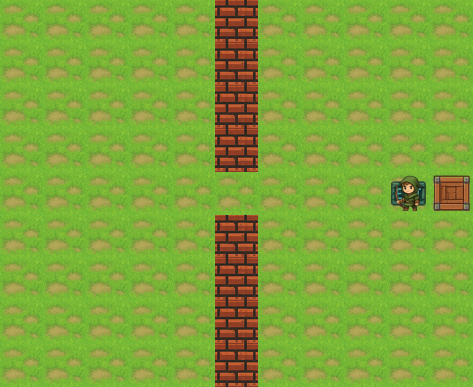

Congratulations! You have exited the maze!


In [52]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for i in range(8):
    action_sequence.append(Action.RIGHT)

agent_id = next(iter(state.agent.keys()))
for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have exited the maze!")
else:
    print("You are stuck here, forever!!!")

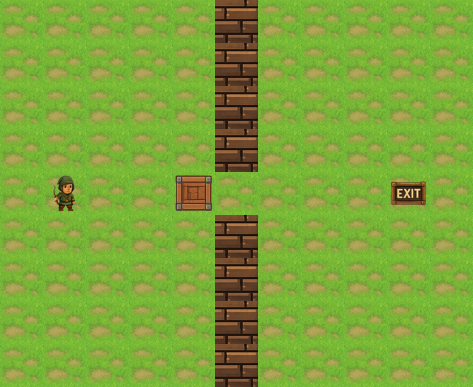

In [42]:
level = Level(
    width=11,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=all_pushable_at_exit_objective_fn,    # win when all boxes are on exits (you do not need to exit)
    seed=21,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if x == 5 and y != 4:
            level.add((x, y), create_wall())

level.add((1, 4), create_agent(health=5))
level.add((9, 4), create_exit())
level.add((4, 4), create_box())

# 3) Convert to runtime State (immutable)
state = to_state(level)
renderer_large.render(state)

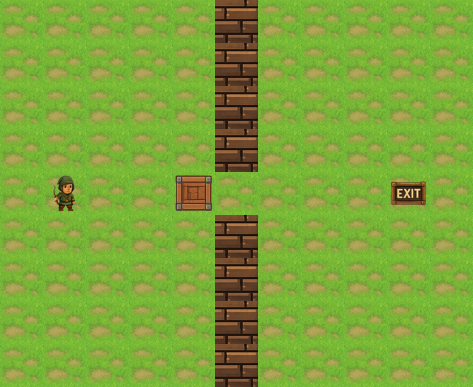

You are stuck here, forever!!!


In [43]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have pushed the box to the exit!")
else:
    print("You are stuck here, forever!!!")

### Level 6, 9 - Hazard Detour, Enemy Patrol

> Now, you may die.

| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |
| L1 | Maze turns | Blocking |
| L2 | Optional Coins | Collectible, Rewardable, Cost |
| L3 | One Required Core | Required |
| L4 | Two Required Cores | Required |
| L5 | Key & Door | Key, Locked |
| L6 | Hazard Detour | Health, Damage, LethalDamage |
| L7 | Portal Shortcut | Portal |
| L8 | Pushing Boxes | Collidable, Moving, Pushable |
| L9 | Enemy Patrol | Pathfinding |

Hazards: tiles are hazardous if they have `Damage` or `LethalDamage`. Because there's damage, the agent (and other entities) have `Health`.

Each turn, if an entity with `Health` shares a tile with a `Damage` source (standing on lava, touching an enemy, etc.), subtract that damage amount. If it's `LethalDamage`, set health to 0. If the agent's health hits 0, you lose regardless of objective progress.

`Health` attributes:
- `health`: Current HP (clamped to `[0, max_health]`)
- `max_health`: Maximum HP

By default the agent starts with 5 health. Reach the exit in the two cases below.

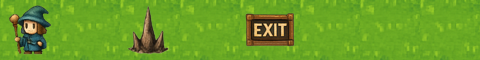

In [44]:
from grid_universe.levels.factories import create_hazard
from grid_universe.components.properties.appearance import AppearanceName

level = Level(width=8, height=1, 
    move_fn=default_move_fn, 
    objective_fn=exit_objective_fn, # reach the exit to win
    seed=22,
)

for y in range(8):
    for x in range(1):
        level.add((y, x), create_floor())

portal = create_portal()

level.add((0, 0), create_agent()) # 5 health by default
level.add((2, 0), create_hazard(appearance=AppearanceName.SPIKE, damage=2)) # the spike deals 2 damage
level.add((4, 0), create_exit())

state = to_state(level)
agent_id = next(iter(state.agent.keys()))

display(renderer_large.render(state))

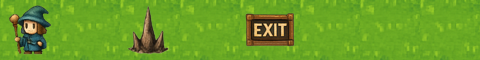

You are stuck here, forever!!!


In [45]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have reached the exit!")
elif state.lose:
    print("You died.")
else:
    print("You are stuck here, forever!!!")

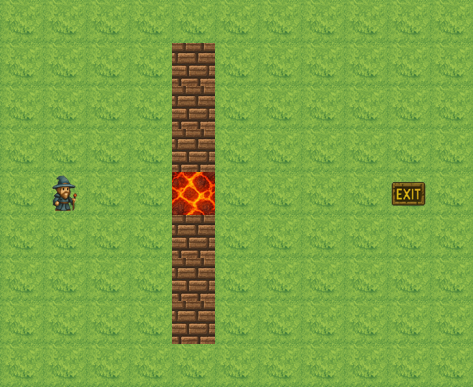

In [46]:
level = Level(
    width=11,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # reach the exit to win
    seed=23,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if x == 4 and y not in (0, 4, 8):
            level.add((x, y), create_wall())

level.add((1, 4), create_agent(health=5))
level.add((9, 4), create_exit())
level.add((4, 4), create_hazard(appearance=AppearanceName.LAVA, damage=2, lethal=True)) # You will die on contact with lava

# 3) Convert to runtime State (immutable)
state = to_state(level)
agent_id = next(iter(state.agent.keys()))

renderer_large.render(state)

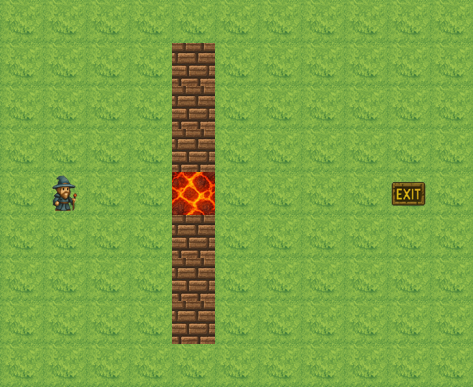

You are stuck here, forever!!!


In [47]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have reached the exit!")
elif state.lose:
    print("You died.")
else:
    print("You are stuck here, forever!!!")

Enemies also deal damage. Like hazards they can be `Damage` or `LethalDamage`, and like boxes they are `Collidable` (so they can teleport, trigger interactions, etc.).

Two enemy categories:
- Pre‑programmed movers (`Moving` type) – see Level 8.
- Active hunters that approach the player.

A pathfinding entity includes:
- `pathfind_target_ref` (`Optional[EntitySpec]`): entity to pursue. If `None` and `pathfinding_type` is `PATH`, the system may skip or use a default goal.
- `pathfinding_type` (`Optional[PathfindingType]`):
  - `PATH`: full search (e.g. A*)
  - `STRAIGHT_LINE`: axis-aligned greedy drift without obstacle search

Escape the two lethal patrolling enemies below.

Hint: Use `Action.WAIT` to let them pass.

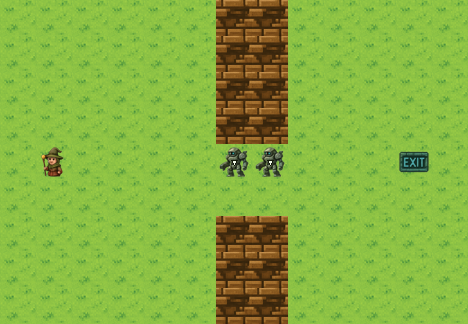

In [57]:
from grid_universe.levels.factories import create_monster

level = Level(
    width=13,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # reach the exit to win
    seed=24,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if x in (6, 7) and y not in (4, 5):
            level.add((x, y), create_wall())

level.add((1, 4), create_agent(health=5))
level.add((11, 4), create_exit())

level.add((6, 4), create_monster(lethal=True, moving_axis=MovingAxis.VERTICAL, moving_direction=1))
level.add((7, 4), create_monster(lethal=True, moving_axis=MovingAxis.VERTICAL, moving_direction=1))

# 3) Convert to runtime State (immutable)
state = to_state(level)
agent_id = next(iter(state.agent.keys()))

renderer_large.render(state)

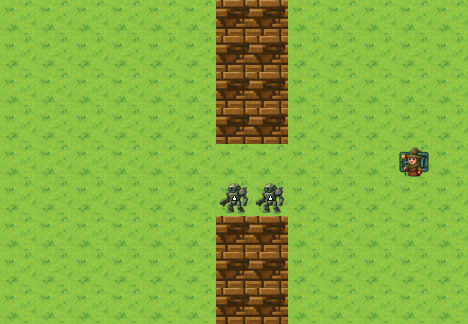

Congratulations! You have reached the exit!


In [59]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for i in range(10):
    action_sequence.append(Action.RIGHT)

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have reached the exit!")
elif state.lose:
    print("You died.")
else:
    print("You are stuck here, forever!!!")

Now a lethal enemy will chase you with A*. Run!

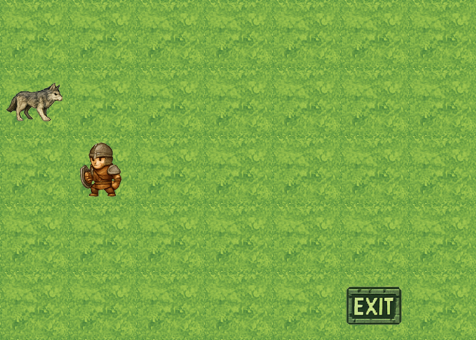

In [50]:
from grid_universe.levels.factories import create_monster
from grid_universe.components.properties.pathfinding import PathfindingType

level = Level(
    width=7,
    height=5,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # reach the exit to win
    seed=25,                          # for reproducibility
)

# 2) Layout: floors, then place objects
for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

agent = create_agent()

level.add((1, 2), agent)
level.add((5, 4), create_exit())

level.add((0, 1), create_monster(lethal=True, pathfind_target=agent, path_type=PathfindingType.PATH))

# 3) Convert to runtime State (immutable)
state = to_state(level)
agent_id = next(iter(state.agent.keys()))

renderer_large.render(state)

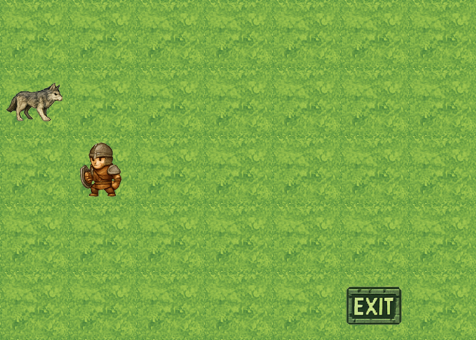

You are stuck here, forever!!!


In [51]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for a in action_sequence:
    display(renderer_large.render(state))
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have reached the exit!")
elif state.lose:
    print("You died.")
else:
    print("You are stuck here, forever!!!")

### Level 10, 11, 12 - Shield, Ghost, Boots Powerups

> Now, you may avoid dying.

| Level | Focus | New Mechanic |
| --- | --- | --- |
| L0 | Basic movement | Exit |
| L1 | Maze turns | Blocking |
| L2 | Optional Coins | Collectible, Rewardable, Cost |
| L3 | One Required Core | Required |
| L4 | Two Required Cores | Required |
| L5 | Key & Door | Key, Locked |
| L6 | Hazard Detour | Health, Damage, LethalDamage |
| L7 | Portal Shortcut | Portal |
| L8 | Pushing Boxes | Collidable, Moving, Pushable |
| L9 | Enemy Patrol | Pathfinding |
| L10 | Shield Powerup | Immunity, TimeLimit, UsageLimit |
| L11 | Ghost Powerup | Phasing |
| L12 | Boots Powerup | Speed |

The Grid is benevolent enough to offer three powerups—`Collectible` entities whose effects trigger when picked up. Each powerup combines `TimeLimit` (duration; `None` = no expiry) and `UsageLimit` (uses; `None` = unlimited). The effect ends when either duration expires or uses are exhausted (whichever first).

#### **Ghost Powerup**

A `Phasing` effect: you can pass through `Blocking` entities. If a usage limit exists, one use is consumed each time you phase through a blocking tile.

`Collidable` interactions still apply: you can teleport, push boxes, but you will not take damage from enemies. When phasing ends you are not auto‑ejected from inside walls. If at least one adjacent orthogonal non‑blocking tile exists, you can move out. If surrounded on all four sides by blocking tiles, you are stuck—forever.

Try the Ghost powerup:

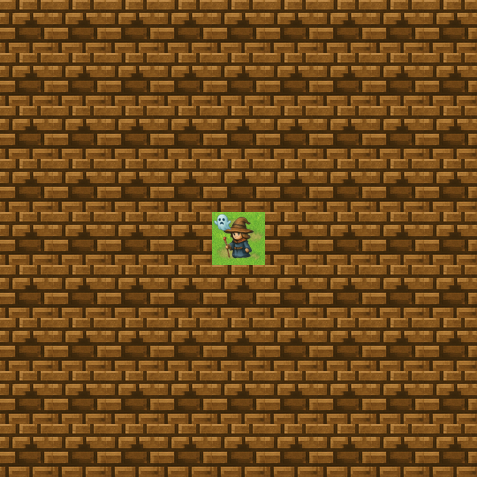

In [52]:
from grid_universe.levels.factories import create_phasing_effect
level = Level(
    width=9,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand
    seed=26                           # for reproducibility
)

for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if (x, y) != (4, 4):
            level.add((x, y), create_wall())

level.add((4, 4), create_agent())
# For 3 turns, can walk through walls
# The phasing effect is on top of the agent, remember to pick it up!
level.add((4, 4), create_phasing_effect(time=3)) 

state = to_state(level)
agent_id = next(iter(state.agent.keys()))
renderer_large.render(state)

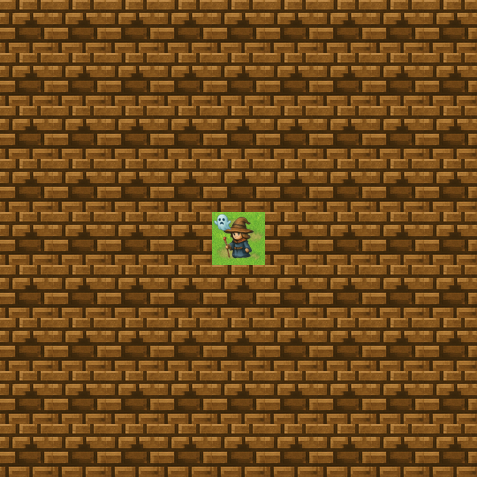

In [53]:
# Trap yourself in the wall.
action_sequence: List[Action] = [] 

for a in action_sequence:
    display(renderer_large.render(state))
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))

Now phase to escape this maze split into two partitions.

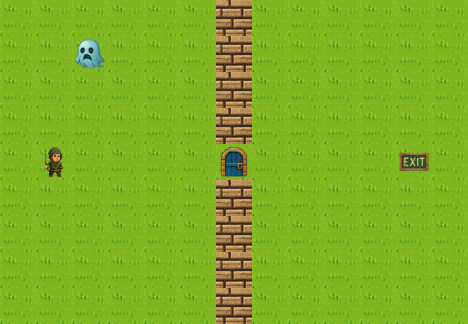

In [54]:
from grid_universe.levels.factories import create_phasing_effect, create_speed_effect, create_immunity_effect
level = Level(
    width=13,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=123                           # for reproducibility
)

for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if x == 6:
            if y == 4:
                level.add((x, y), create_door(key_id="my_key"))
            else:
                level.add((x, y), create_wall())

level.add((1, 4), create_agent())
level.add((11, 4), create_exit())
level.add((2, 1), create_phasing_effect(time=5)) # For 5 turns, can walk through walls

state = to_state(level)
agent_id = next(iter(state.agent.keys()))
renderer_large.render(state)

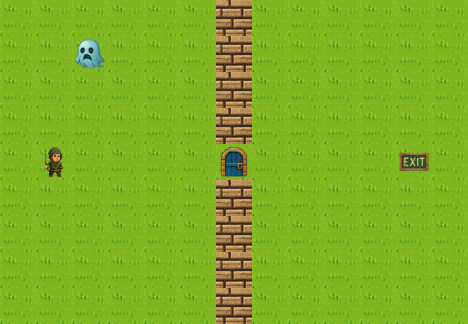

You are stuck here, forever!!!


In [55]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have reached the exit!")
elif state.lose:
    print("You died.")
else:
    print("You are stuck here, forever!!!")

#### **Shield Powerup**

An `Immunity` effect: you ignore damage. If a usage limit exists, a use is consumed only when damage would have been applied. Lethal damage also counts as a single hit, letting you survive it while immunity lasts.

Test the Shield powerup across this deadly lava separation.

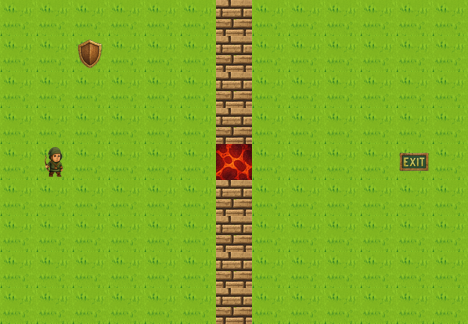

In [56]:
level = Level(
    width=13,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=123                           # for reproducibility
)

for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if x == 6:
            if y == 4:
                level.add((x, y), create_hazard(appearance=AppearanceName.LAVA, damage=5, lethal=True))
            else:
                level.add((x, y), create_wall())

level.add((1, 4), create_agent())
level.add((11, 4), create_exit())
level.add((2, 1), create_immunity_effect(usage=1)) # You arre immune to damage once.

state = to_state(level)
agent_id = next(iter(state.agent.keys()))
renderer_large.render(state)

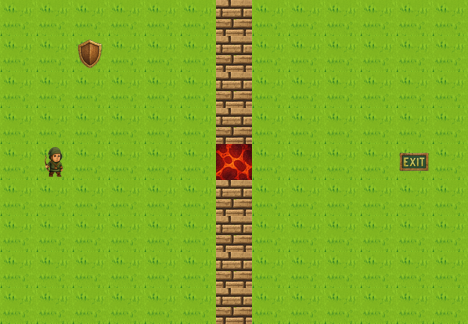

You are stuck here, forever!!!


In [57]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have reached the exit!")
elif state.lose:
    print("You died.")
else:
    print("You are stuck here, forever!!!")

#### **Speed Powerup**

A `Speed` effect: adds a movement multiplier. If multiplier = 2 you move 2 tiles in the chosen orthogonal direction (no diagonal decomposition) assuming nothing blocks intermediate tiles. If a usage limit exists, any movement action consumes one use.

`Speed` lets you buy time against pathfinders, or simply exit faster. `Speed` does not allow you to phase through enemies without taking damage, that is, if you attempt to vault over a `Damage` tile using `Speed`, you will take damage as per usual. For example, on turn `n`, you are posessing a `Speed` and wants to go to a tile somewhere away on turn `n+1`. The enemy movement is calculated first. If the trail that you take to move to that tile intersects with the enemy/lava/spike position on turn `n+1`, then you take damage as usual, even if the resulting tile is not the enemy/lava/spike tile on turn `n+1`.

Escape this enemy‑patrolled grid using speed.

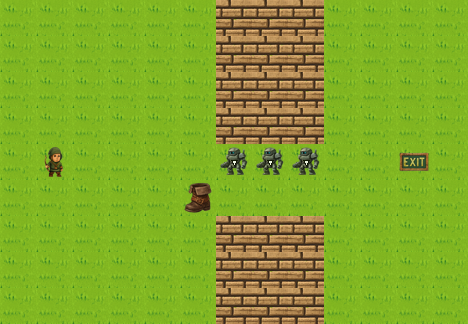

In [58]:
from grid_universe.levels.factories import create_speed_effect
level = Level(
    width=13,
    height=9,
    move_fn=default_move_fn,           # choose movement semantics
    objective_fn=exit_objective_fn,    # win when stand on exit
    seed=123                           # for reproducibility
)

for y in range(level.height):
    for x in range(level.width):
        level.add((x, y), create_floor())

        if 6 <= x <= 8:
            if y == 4:
                level.add((x, y), create_monster(lethal=True, moving_axis=MovingAxis.VERTICAL, moving_direction=1))
            elif y == 5:
                continue
            else:
                level.add((x, y), create_wall())

level.add((1, 4), create_agent())
level.add((11, 4), create_exit())
level.add((5, 5), create_speed_effect(multiplier=2, time=3)) # For 3 turns, your speed is doubled

state = to_state(level)
agent_id = next(iter(state.agent.keys()))
renderer_large.render(state)

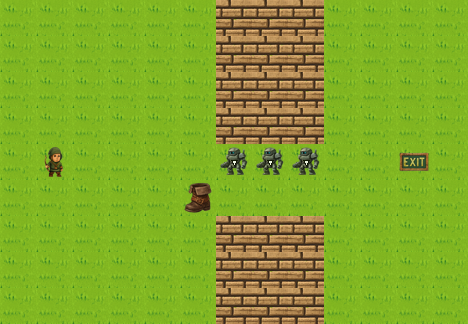

You are stuck here, forever!!!


In [59]:
action_sequence: List[Action] = [] # Fill in the sequence of actions here!

for a in action_sequence:
    state = step(state, a, agent_id=agent_id)

display(renderer_large.render(state))
if state.win:
    print("Congratulations! You have reached the exit!")
elif state.lose:
    print("You died.")
else:
    print("You are stuck here, forever!!!")

## Final Note

With that, you've mastered the Grid Universe. Enjoy gridding!